In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from tpot import TPOTRegressor

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='whitegrid')


C:\Users\User\PycharmProjects\PythonProject11\.venv\lib\site-packages\seaborn\utils.py:10: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.0)
  from scipy import stats
C:\Users\User\PycharmProjects\PythonProject11\.venv\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


## **1. Analiza danych**
Wczytanie

In [3]:
data = pd.read_csv('data/Housing.csv')

Sprawdzenie informacji

In [4]:
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


Sprawdzenie brakujących wartości

In [5]:
missing_values = data.isnull().sum()
print("Brakujące wartości")
print(missing_values[missing_values > 0])


Brakujące wartości
Series([], dtype: int64)


Analiza numerowanych

Zmienne numerowane: ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']


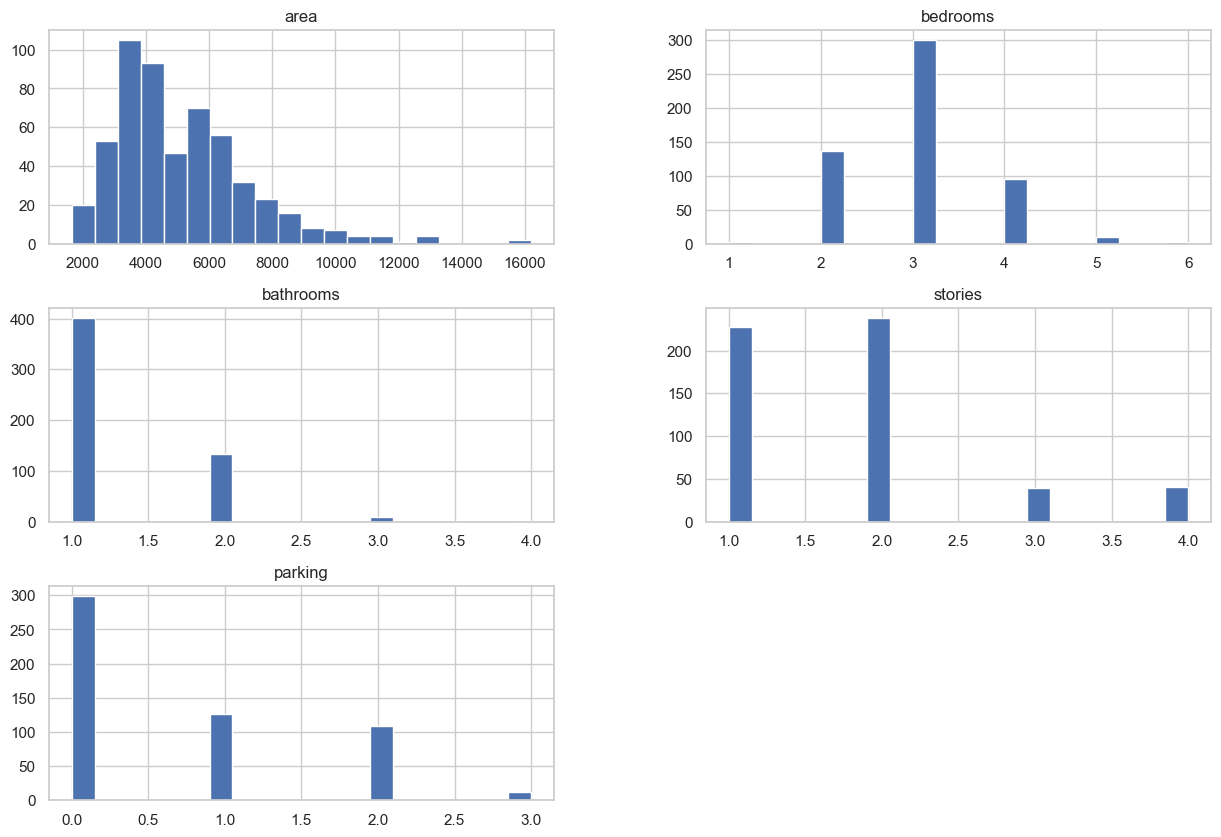

In [6]:
num_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Zmienne numerowane:", num_cols)

num_cols.remove('price')

data[num_cols].hist(figsize=(15, 10), bins=20)
plt.show()


Analiza kategorii


Zmienne kategorii: ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


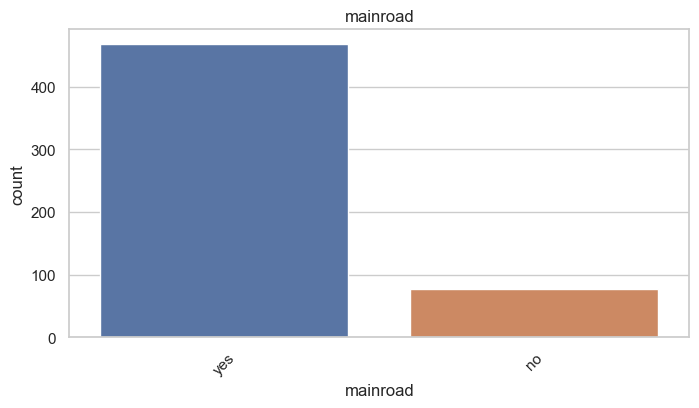

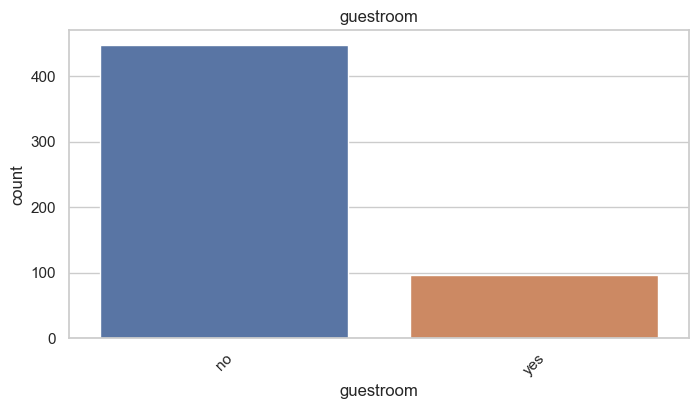

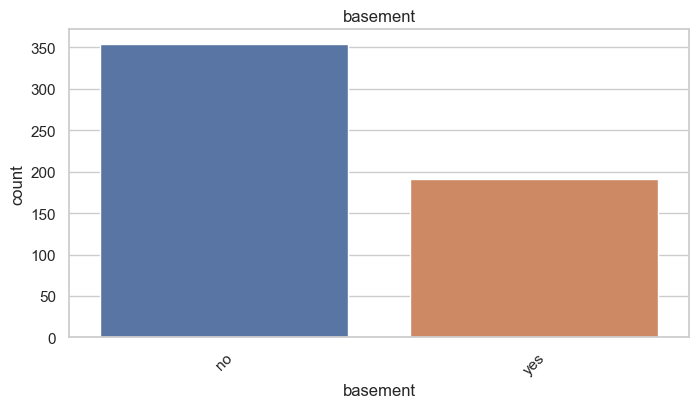

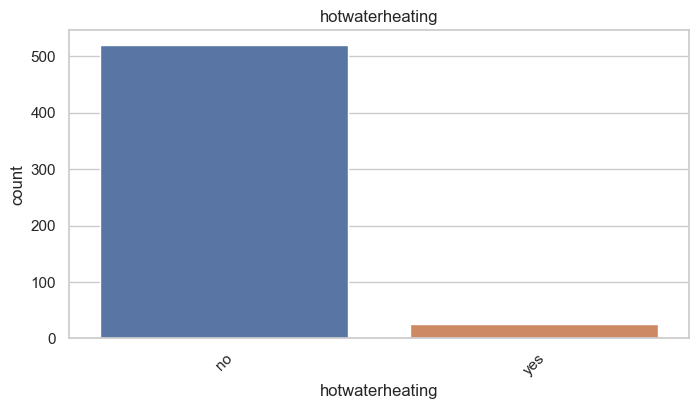

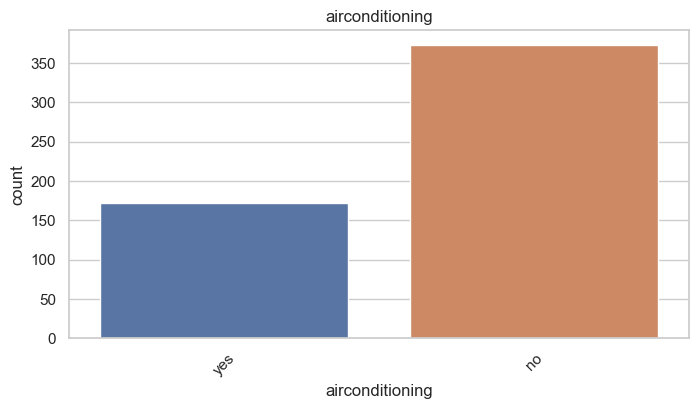

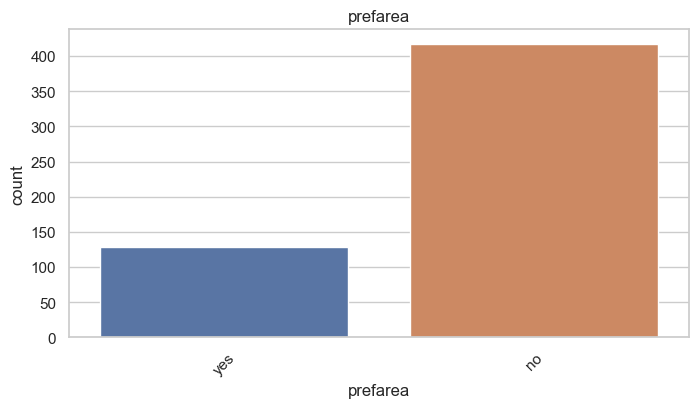

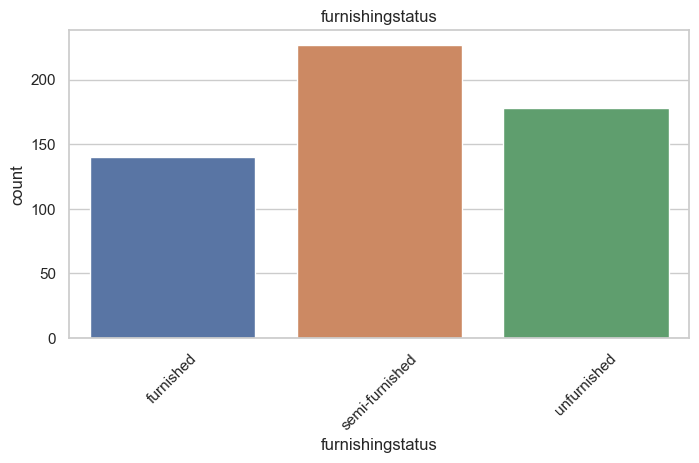

In [7]:
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
print("Zmienne kategorii:", cat_cols)

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data[col])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()


Wizualizacja brakujących

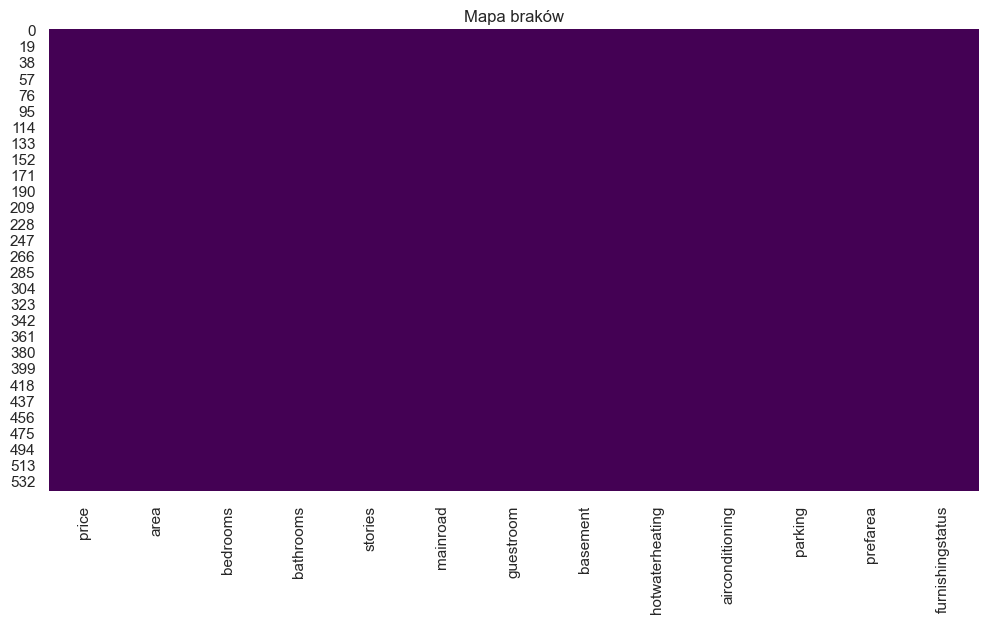

In [8]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Mapa braków')
plt.show()


Wykresydla zmiennych numerowanych

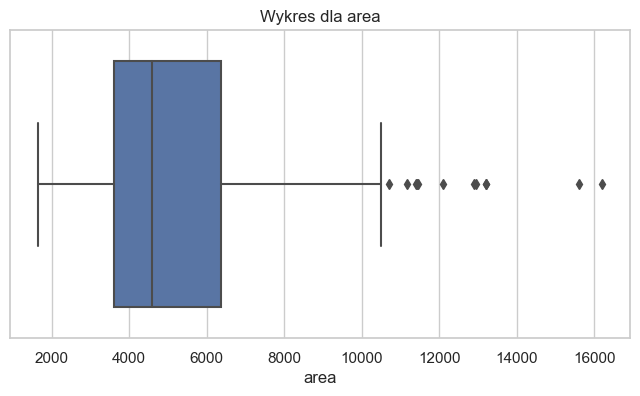

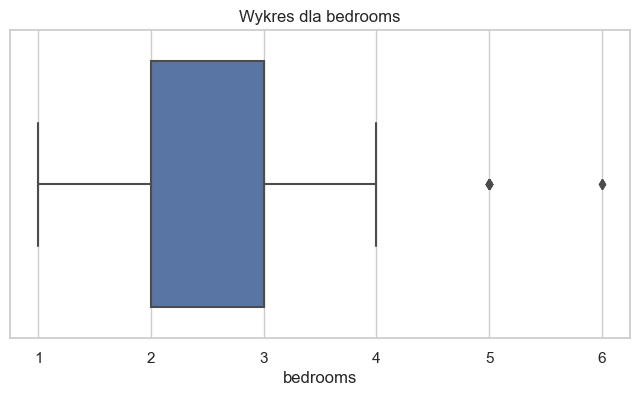

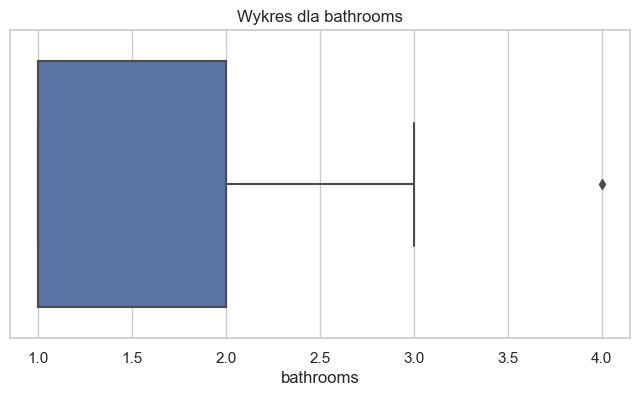

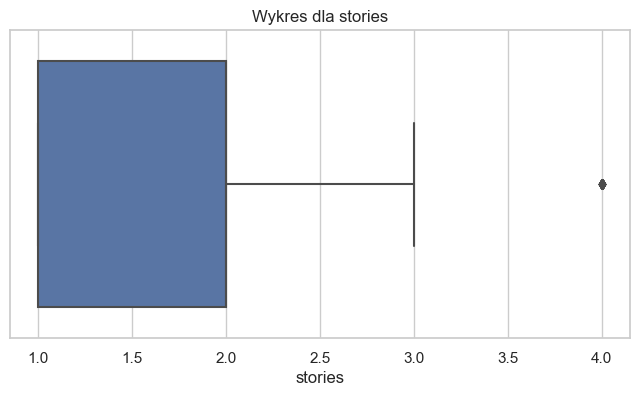

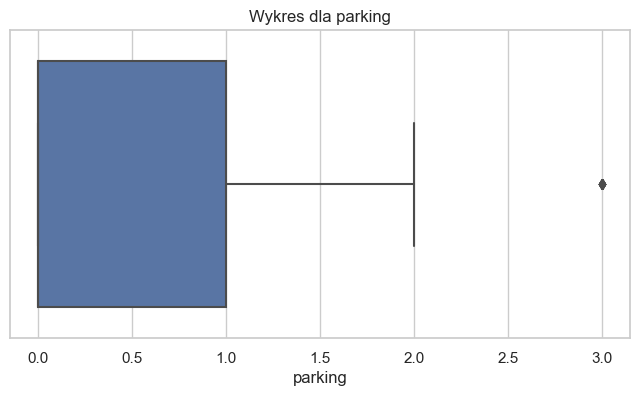

In [9]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Wykres dla {col}')
    plt.show()


Macierz korelacji

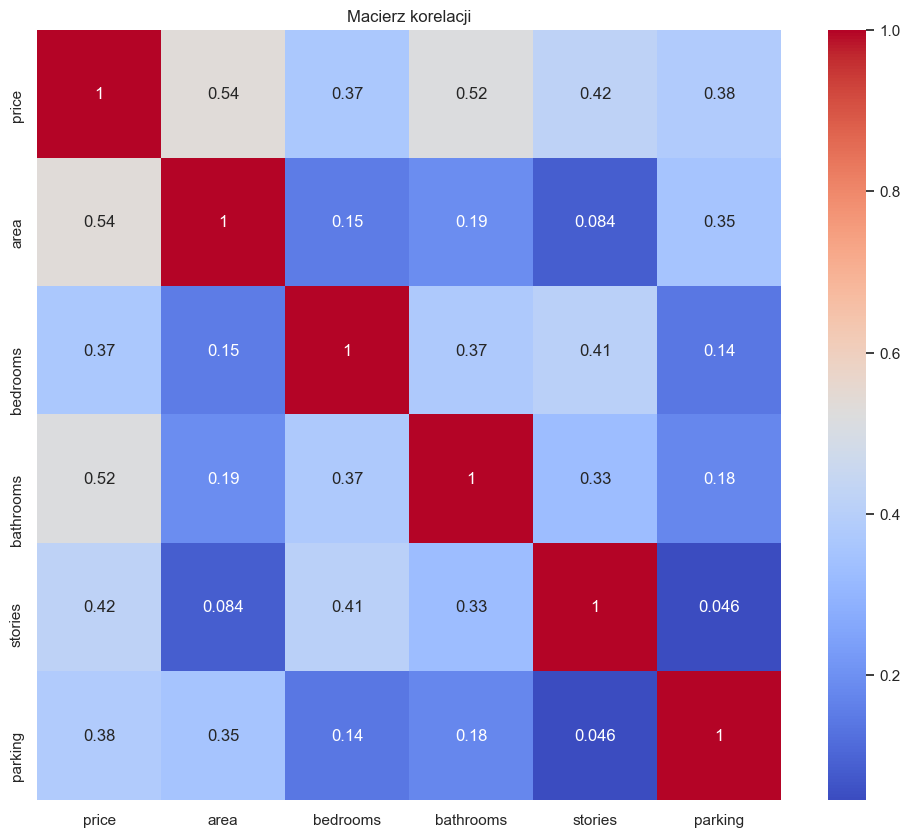

In [10]:
corr_matrix = data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Macierz korelacji')
plt.show()


raport z Pandas Profiling

In [12]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title='Raport Pandas Profiling', explorative=True)
profile.to_file("reports/pandas_profiling_report.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 210.45it/s]


Analiza raportu
Główne obserwacje z raportu:

- Area jest silnie skorelowane z Price (wysoka korelacja).
- Price jest silnie skorelowane z Area (wysoka korelacja).
- Bathrooms jest silnie niezrównoważone (52.8% jednej kategorii).
- HotWaterHeating jest silnie niezrównoważone (73.1% jednej kategorii).

Wnioski:

- Area jest ważnym predyktorem Price i powinien być uwzględniony w modelu.
- Należy zwrócić uwagę na zmienne niezrównoważone, ale w przypadku modeli drzewiastych nie stanowi to dużego problemu.


2. Wykorzystanie narzędzia do doboru odpowiednich modeli
2.1 Przygotowanie danych
2.1.1 implementacja brakujących wartości

In [13]:
num_imputer = SimpleImputer(strategy='mean')
data[num_cols] = num_imputer.fit_transform(data[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
data[cat_cols] = cat_imputer.fit_transform(data[cat_cols])


2.1.2 Kodowanie zmiennych kategorycznych i skalowanie cech

In [14]:
data_encoded = pd.get_dummies(data, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
data_encoded[num_cols] = scaler.fit_transform(data_encoded[num_cols])

2.1.3 Usunięcie silnie skorelowanych cech

In [15]:
corr_matrix = data_encoded.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print(f"Cechy do usunięcia: {to_drop}")

data_encoded = data_encoded.drop(columns=to_drop)


Cechy do usunięcia: []


2.2 Podział danych na cechy i zmienną docelową

In [16]:
X = data_encoded.drop('price', axis=1)
y = data_encoded['price']


2.3 Wykorzystanie TPOT do doboru modeli

In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

tpot = TPOTRegressor(
    generations=8,
    population_size=80,
    cv=5,
    scoring='r2',
    verbosity=2,
    random_state=68,
    n_jobs=-1
)

tpot.fit(X_train, y_train)

y_pred = tpot.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Wynik R²: {r2}")

tpot.export('tpot_best_model.py')

Version 0.11.7 of tpot is outdated. Version 0.12.2 was released Friday February 23, 2024.


                                                                              
Generation 1 - Current best internal CV score: 0.6321233941566332
                                                                              
Generation 2 - Current best internal CV score: 0.6321233941566332
                                                                              
Generation 3 - Current best internal CV score: 0.6325276939978307
                                                                              
Generation 4 - Current best internal CV score: 0.6348764689267204
                                                                              
Generation 5 - Current best internal CV score: 0.6371258922579287
                                                                              
Generation 6 - Current best internal CV score: 0.6371258922579287
                                                                              
Generation 7 - Current best internal CV score: 0.63

2.4 Dodatkowe sprawdzenie modeli

In [18]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RandomForestRegressor R² Score: {r2_rf}")


RandomForestRegressor R² Score: 0.5722897945547283


2.5 Hyperparameter Tuning

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import r2_score

base_models = [
    ('decision_tree', DecisionTreeRegressor(random_state=42)),
    ('ridge', RidgeCV())
]

stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV()
)

pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('stacking', stacking_regressor)
])

param_grid = {
    'stacking__decision_tree__max_depth': [1, 2, 3, 5, 7, 10],
    'stacking__decision_tree__min_samples_leaf': [1, 2, 5, 7, 10],
    'stacking__decision_tree__min_samples_split': [2, 5, 10, 20],
    'stacking__decision_tree__criterion': ['mse', 'friedman_mse', 'mae', 'poisson']
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='r2'
)

grid_search.fit(X_train, y_train)

print("Najlepsze parametry dla StackingRegressor:", grid_search.best_params_)
print("Najlepszy wynik CV R²:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f"StackingRegressor R² na zbiorze testowym: {r2}")


Najlepsze parametry dla StackingRegressor: {'stacking__decision_tree__criterion': 'mse', 'stacking__decision_tree__max_depth': 5, 'stacking__decision_tree__min_samples_leaf': 5, 'stacking__decision_tree__min_samples_split': 2}
Najlepszy wynik CV R²: 0.6495933132961306
StackingRegressor R² na zbiorze testowym: 0.6258195678831251


In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_poly = scaler.fit_transform(X_train_poly)
X_test_poly = scaler.transform(X_test_poly)

stacking_model = grid_search.best_estimator_.named_steps['stacking']

stacking_model.fit(X_train_poly, y_train)

y_pred_poly = stacking_model.predict(X_test_poly)

r2_poly = r2_score(y_test, y_pred_poly)
print(f"StackingRegressor z cechami wielomianowymi R²: {r2_poly}")


StackingRegressor z cechami wielomianowymi R²: 0.6378649467866295
